In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamzaraouzi","key":"28388e813c3436f16140fd50d764a55c"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp  kaggle.json  ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 32.6MB/s]
 97% 262M/271M [00:04<00:00, 122MB/s]
100% 271M/271M [00:04<00:00, 64.5MB/s]
 98% 530M/543M [00:04<00:00, 144MB/s]
100% 543M/543M [00:04<00:00, 115MB/s]


In [4]:
from zipfile import ZipFile
file_name="test1.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


In [5]:
from zipfile import ZipFile
file_name="train.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


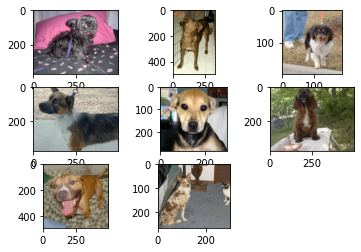

In [6]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
folder='train/'
for i in range(8):
  plt.subplot(330+1+i)
  filename=folder+'dog.'+str(i)+'.jpg'
  image=imread(filename)
  plt.imshow(image)
plt.show()

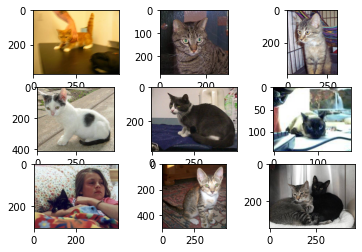

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
folder='train/'
for i in range(9):
  plt.subplot(330+1+i)
  filename=folder+'cat.'+str(i)+'.jpg'
  image=imread(filename)
  plt.imshow(image)
plt.show()

In [8]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class GoogLeNet(nn.Module):

  def __init__(self,aux_logits=True,num_classes=1000):
    super(GoogLeNet,self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(in_channels=3,
                            out_channels=64,
                            kernel_size=(7,7),
                            stride=(2,2),
                            padding=(3,3))
    
    self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.conv2 = conv_block(64,192,kernel_size=3,stride=1,padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    # in this order: in_channels , out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192,64,96,128,16,32,32)
    self.inception3b = Inception_block(256,128,128,192,32,96,64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64,64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4    = nn.MaxPool2d(kernel_size= 3,stride=2,padding=1)
    
    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    ##########################################################################
    
    self.avgpool = nn.AvgPool2d(kernel_size=7,stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024,num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512,num_classes)
      self.aux2 = InceptionAux(528,num_classes)
    else:
      self.aux1 = self.aux2 = None

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)

    if self.aux_logits and self.training:
      aux1 = self.aux1(x)
      

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    
    if self.aux_logits and self.training:
      aux2 = self.aux2(x)
    
    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
      return aux1,  aux2, x
    else:
      return x


class Inception_block(nn.Module):
    def __init__(self, in_channels,out_1x1,red_3x3,out_3x3,red_5x5,out_5x5,out_1x1pool):
      super(Inception_block, self).__init__()
      self.branche1 = conv_block(in_channels, out_1x1,kernel_size=(1,1))

      self.branche2 = nn.Sequential(
          conv_block(in_channels,red_3x3,kernel_size=(1,1)),
          conv_block(red_3x3,out_3x3,kernel_size=(3,3),padding=(1,1))
      )

      self.branche3 = nn.Sequential(
          conv_block(in_channels,red_5x5,kernel_size=(1,1)),
          conv_block(red_5x5,out_5x5,kernel_size=(5,5),padding=(2,2))        
      )
      
      self.branche4 = nn.Sequential(
          nn.MaxPool2d(kernel_size=(3,3),stride=(1,1),padding=(1,1)),
          conv_block(in_channels,out_1x1pool,kernel_size=(1,1))
      )

    def forward(self, x):
     
      return torch.cat([
                        self.branche1(x),self.branche2(x),self.branche3(x),self.branche4(x)
      ],1)

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
  
        return x



class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels,**kwrags):
    super(conv_block,self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels,out_channels,**kwrags)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [10]:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)   
    x = torch.randn(3, 3, 224, 224)
    model = GoogLeNet(aux_logits=True, num_classes=2)
    print(model(x)[2])

cuda:0
tensor([[-0.1522, -0.1643],
        [ 0.2388,  0.0190],
        [ 0.0421, -0.1676]], grad_fn=<AddmmBackward>)


In [11]:
from torchvision import datasets, transforms
#Applying Transformation
train_transforms = transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])
train_data = datasets.ImageFolder(dataset_home  + '/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(dataset_home + '/test', 
                                    transform=test_transforms)

#Data Loading
trainloader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=32)
testloader = torch.utils.data.DataLoader(test_data,shuffle=True ,batch_size=32)

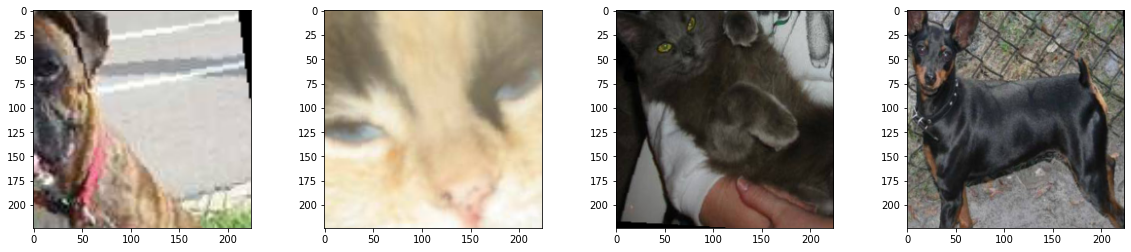

In [12]:
import numpy as np
data_iter = iter(trainloader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(20,4),ncols=4)
for ii in range(4):
  ax = axes[ii]
  ax.imshow(np.transpose(images[ii].numpy(),(1,2,0)))


In [13]:
accuracy_list = []

def train(epoch,model):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        # send to device
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        aux_1_out, aux_2_out, final_output = model(data)
        
        loss1 = nn.CrossEntropyLoss()(final_output, target)
        loss2 = nn.CrossEntropyLoss()(aux_1_out, target)
        loss3 = nn.CrossEntropyLoss()(aux_2_out, target)

        loss = loss1 + 0.3*loss2 + 0.3*loss3

        loss.backward()
        optimizer.step()
       
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


In [16]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = model(data)
            #sum up batch loss 
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)

            correct += predicted.eq(target).sum().item()
        
        
        test_loss /= len(testloader.dataset)
        accuracy = 100.*correct/len(testloader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct,len(testloader.dataset),
            accuracy
        ))

    return accuracy,test_loss

In [ ]:
model.to(device)

PATH ='model.pt'

optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9)
prev_test_accuracy =-1
for epoch in range(0,100):
  
    model.aux_logits = True
    train(epoch,model)
    model.aux_logits = False
    test_accuracy,test_loss = test(model)

    if test_accuracy >prev_test_accuracy:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                }, PATH)
        print("weights from epoch {} has been saved ".format(epoch))
        prev_test_accuracy = test_accuracy

In [20]:
loaded_model = GoogLeNet(aux_logits=True, num_classes=2)

optimizer = optim.SGD(loaded_model.parameters(), lr=0.001,
                      momentum=0.9)

checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

loaded_model.to(device)
loaded_model.eval()
loaded_model.aux_logits= False
test_accuracy,test_loss= test(loaded_model)


Test set: Average loss: 0.0038, Accuracy: 6017/6303 (95%)

